In [15]:
import torch
import random
import cv2
import numpy as np
import pandas as pd
import seaborn as sn
from torch import nn
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix

In [2]:
header = ['img_path', 'class']
dataset = pd.read_csv('dataset.csv', names = header)

In [3]:
images = []
labels = []
for i in range(len(dataset)):   
    img = cv2.imread(dataset.iloc[i, 0])
    label = dataset.iloc[i,1]
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (28,28), interpolation = cv2.INTER_CUBIC)
    img = img.reshape(1, 28,28)
    images.append(img/255)
    labels.append(label)

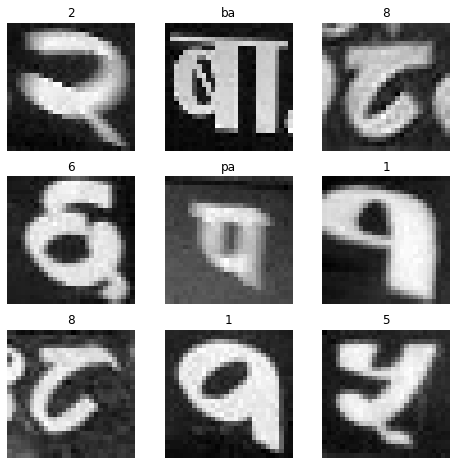

In [4]:
row, col = 3, 3
figure = plt.figure(figsize=(8,8))
for i in range(1,row*col + 1):
    index = random.randint(1, len(dataset))
    img, label = images[index], labels[index]
    img = img.reshape(28,28)
    if label == 10:
        label = 'ba'
    elif label == 11:
        label = 'pa'
    figure.add_subplot(row, col, i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(img, cmap='gray')

In [5]:
train_data, test_data, train_label, test_label = train_test_split(images, labels, shuffle=True, random_state=10, train_size=0.9)
train_data = torch.tensor(train_data).float()
test_data   = torch.tensor(test_data).float()
train_label = torch.tensor(train_label)
test_label = torch.tensor(test_label)

In [6]:
batch_size = 10
train = TensorDataset(train_data, train_label)
test = TensorDataset(test_data, test_label)
train_loader = DataLoader(train, batch_size = batch_size)
test_loader = DataLoader(test, batch_size = batch_size)

In [7]:
class ConvNeural(nn.Module):
    def __init__(self):
        super(ConvNeural, self).__init__()
        self.forward_propogation = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels = 16, kernel_size = 3, stride = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, stride = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2),
            
            nn.Flatten(),
            nn.Linear(32*5*5,16 , bias=True),
            nn.ReLU(),
            
            nn.Linear(16, 12, bias = True),
            nn.ReLU(),
        )
    
    def forward(self, x):
        output = self.forward_propogation(x)
        return output

model = ConvNeural()
print(model)

ConvNeural(
  (forward_propogation): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=800, out_features=16, bias=True)
    (8): ReLU()
    (9): Linear(in_features=16, out_features=12, bias=True)
    (10): ReLU()
  )
)


In [8]:
learning_rate = 0.13
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [9]:
def train(data_dataloader , model, loss_fn, optimizer):
    size = len(data_dataloader.dataset)
    lossess = []
    accuracies = []
    for batch, (x, y) in enumerate(data_dataloader):
        pred = model(x)
        loss = loss_fn(pred, y)
        cat =  torch.argmax(pred, dim=1)
        accuracy = (cat == y).float().mean()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 20 == 0:
            loss, current = loss.item(), batch* len(x)
            print(f"Loss: {loss:>7f}   [{current:>5d}/{size:>5d}] Accuracy: {accuracy * 100:>7f}")
            lossess.append(loss)
            accuracies.append(accuracy)
    return lossess, accuracies

In [10]:
def test(data_dataloader, model):
    size = len(data_dataloader.dataset)
    model.eval()
    test_loss, correct = 0,0
    with torch.no_grad():
        for (x, y) in data_dataloader:
            pred = model(x)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"\n Test Error: \n Avg loss: {test_loss:>8f} Test Accuracy:{correct * 100:>5f}% \n")

In [11]:
epochs = 8
losses , accuracies = [], []
for t in range(epochs):
    print(f"Epoch {t+1}\n----------------------------------------")
    loss, accuracy = train(train_loader, model, loss_fn, optimizer)
    for l, a in zip(loss, accuracy):
        losses.append(l)
        accuracies.append(a)
    test(test_loader, model)


Epoch 1
----------------------------------------
Loss: 2.482088   [    0/ 1829] Accuracy: 10.000000
Loss: 2.482714   [  200/ 1829] Accuracy: 10.000000
Loss: 2.503807   [  400/ 1829] Accuracy: 10.000000
Loss: 2.442144   [  600/ 1829] Accuracy: 10.000000
Loss: 2.475622   [  800/ 1829] Accuracy: 10.000000
Loss: 2.486411   [ 1000/ 1829] Accuracy: 10.000000
Loss: 2.471748   [ 1200/ 1829] Accuracy: 20.000000
Loss: 2.442957   [ 1400/ 1829] Accuracy: 30.000002
Loss: 2.463773   [ 1600/ 1829] Accuracy: 10.000000
Loss: 2.529727   [ 1800/ 1829] Accuracy: 0.000000

 Test Error: 
 Avg loss: 0.255741 Test Accuracy:7.352941% 

Epoch 2
----------------------------------------
Loss: 2.461874   [    0/ 1829] Accuracy: 10.000000
Loss: 2.436638   [  200/ 1829] Accuracy: 20.000000
Loss: 2.530798   [  400/ 1829] Accuracy: 10.000000
Loss: 2.456560   [  600/ 1829] Accuracy: 0.000000
Loss: 2.474311   [  800/ 1829] Accuracy: 10.000000
Loss: 2.409733   [ 1000/ 1829] Accuracy: 30.000002
Loss: 2.499329   [ 1200/ 18

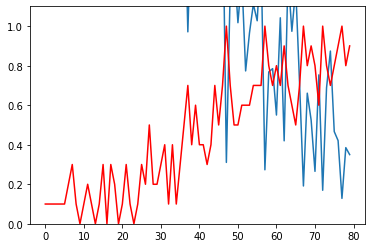

In [12]:
plt.plot(losses)
plt.plot(accuracies,color = "red")
plt.ylim(0,1.1)
plt.show()

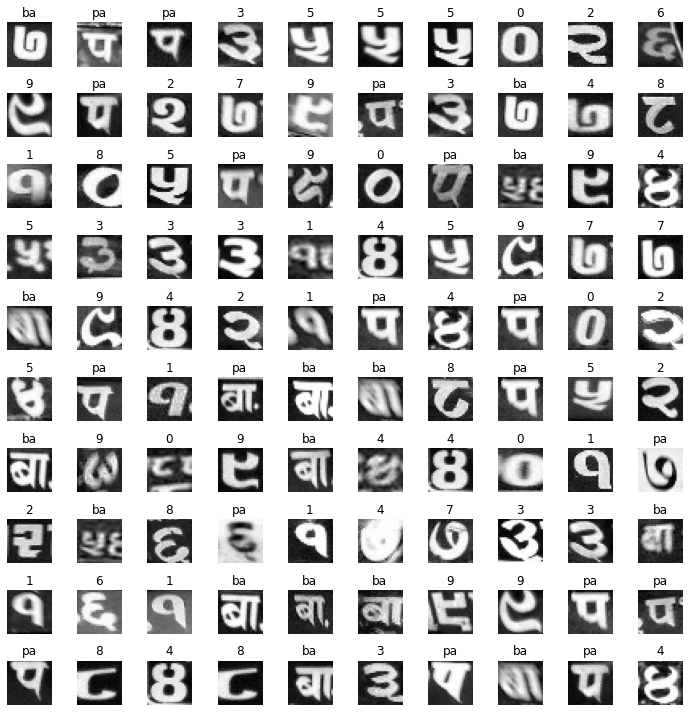

In [13]:
model.eval()
row , col = 10, 10
figure = plt.figure(figsize=(10,10))
for i in range(1, row*col+1):
    index = random.randint(1, len(test_data))
    x, y = test_data[index], test_label[index]
    x = torch.as_tensor(x.reshape(1,1, 28, 28), dtype=torch.float32)
    with torch.no_grad():
        pred = model(x)
        x = x.reshape(28, 28)
        predicted_num = pred[0].argmax(0).item()
        if predicted_num == 10:
            predicted_num = 'ba'
        elif predicted_num == 11:
            predicted_num = 'pa'
        figure.add_subplot(row, col, i)
        plt.title(predicted_num)
        plt.axis('off')
        plt.tight_layout()
        plt.imshow(x, cmap='gray')


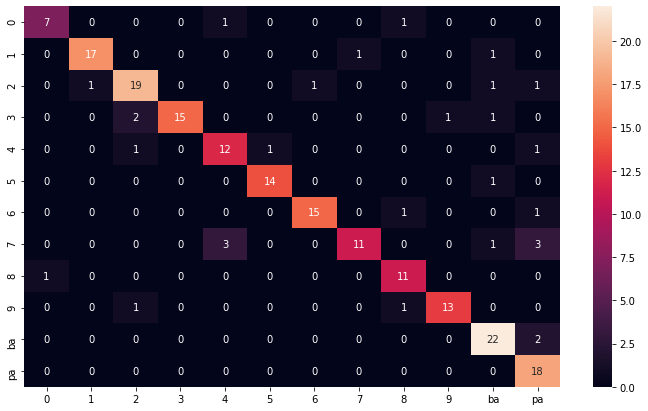

In [20]:
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'ba', 'pa')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.show()